In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/OH/OH_prison_p1_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_policy([], 'prison')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 96 results
transitions_data returned 18 results
total_population_data returned 96 results


In [15]:
test_sim.data_dict['outflows_data']

,simulation_tag,time_step,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,OH_prison_p1,-3,pretrial,prison,485.0,None,F-4,None,None,2021-01-08 22:34:55.788510+00:00
1,OH_prison_p1,-2,pretrial,prison,431.0,None,F-4,None,None,2021-01-08 22:34:55.788510+00:00
2,OH_prison_p1,-1,pretrial,prison,413.0,None,F-4,None,None,2021-01-08 22:34:55.788510+00:00
3,OH_prison_p1,0,pretrial,prison,376.0,None,F-4,None,None,2021-01-08 22:34:55.788510+00:00
4,OH_prison_p1,-3,pretrial,prison,1364.0,None,F-5,None,None,2021-01-08 22:34:55.788510+00:00
5,OH_prison_p1,-2,pretrial,prison,1212.0,None,F-5,None,None,2021-01-08 22:34:55.788510+00:00
6,OH_prison_p1,-1,pretrial,prison,1161.0,None,F-5,None,None,2021-01-08 22:34:55.788510+00:00
7,OH_prison_p1,0,pretrial,prison,1059.0,None,F-5,None,None,2021-01-08 22:34:55.788510+00:00


initialization time:  35.448259115219116
simulation_time:  33.28762888908386
initialization time:  37.56394910812378
simulation_time:  31.804199934005737


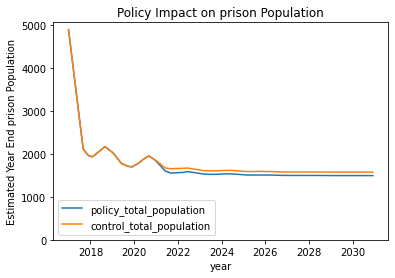

In [9]:
# Policy Option Method
diversion_rate = 0.10
affected_fraction = {'treatment_residential': 0.2357 * diversion_rate, 
                     'treatment_non_residential': (1 - 0.2357) * diversion_rate}

def divert_to_treatment(treatment_type):
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=affected_fraction[treatment_type],
                   outflow='prison',
                   new_outflow= treatment_type)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=divert_to_treatment(treatment_type),
                spark_compartment='pretrial',
                sub_population={'crime_type': 'F-4'},
                apply_retroactive=False)
    for treatment_type in affected_fraction
] + [
    SparkPolicy(policy_fn=divert_to_treatment(treatment_type),
                spark_compartment='pretrial',
                sub_population={'crime_type': 'F-5'},
                apply_retroactive=False)
    for treatment_type in affected_fraction
]

test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [10]:
simulation_tag = 'OH_prison_p1_10%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)